In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [3]:
import astropy.wcs as wcs
from astropy.io import fits

In [4]:
from datetime import datetime

In [5]:
from dm.profiles import MassProfileNFW, MassProfileEinasto, MassProfileIsothermal, MassProfileBurkert, MassProfileMoore

In [6]:
plt.style.use('astroph')

### Utils

Helper functions to plot, generate FITS and get WCS.

#### Plot profiles 

In [7]:
def profile_plot(j_factors, l, b, wcs, grid=False, cmap=plt.cm.plasma, **kwargs):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection=wcs)
    im = ax.imshow(j_factors, origin='lower', cmap=cmap, **kwargs)
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label(r"$\dfrac{d\,J(\theta)}{d\Omega} \times \Delta \Omega_{\mathrm{bin}}$",  fontsize=14,  labelpad=10)
    ax.set_aspect('equal')
    ax.set_ylabel(r'$b$ ($\degree$)')
    ax.set_xlabel(r'$\ell$ ($\degree$)')
    if grid:
        for x in range(l.size):
            ax.axvline(x, color='grey', lw=0.3, alpha=0.8)
        for y in range(b.size):
            ax.axhline(y, color='grey', lw=0.3, alpha=0.8)

#### $\theta$ Grid Generator

In [8]:
def generate_grid(l, b):
    L, B = np.meshgrid(l, b)
    thetas = np.arccos(np.cos(L)*np.cos(B))
    return thetas

#### FITS Generator

In [9]:
def generate_fits(data, wcs, filename, factor_type='annihilation'):
    hdu = fits.PrimaryHDU(data, header=wcs.to_header())
    header = hdu.header
    header.set('MAPTYPE', factor_type.upper(), 'J-Factor map type: annihilation or decay')
    header.set('HISTORY', 'Last update in %s'%str(datetime.today().date()))
    hdul = fits.HDUList([hdu])
    hdul.writeto(filename, overwrite=True)

#### WCS Generator

In [10]:
def generate_wcs(l, b, delta_l, delta_b):
    """Specify WCS for the map. 
    
    The reference pixel is the first one, indexed by 1 
    in FORTRAN and FITS convention. Default for us will
    be numpy convention that the first pixel is 0.
    """
    w = wcs.WCS(naxis=2)
    w.wcs.ctype = ['GLON-CAR', 'GLAT-CAR']
    w.wcs.crval = np.array([l[0], b[0]])
    w.wcs.crpix = np.array([1, 1])
    w.wcs.cdelt = np.array([delta_l, delta_b], dtype=np.float64)
    w.wcs.cunit = ['deg', 'deg']
    return w

### Profiles

In [11]:
nfw = MassProfileNFW()
einasto = MassProfileEinasto()
isothermal = MassProfileIsothermal()
burkert = MassProfileBurkert()
moore = MassProfileMoore()

### Maps

| Latitude ($b$) or aperture ($\theta$) | Longitude ($\ell$)|
|:----: |:---:|
| $|b| \leq 5°$| $|\ell| \leq 5°$ |


**Threshold**

There is a integration threshold on $\theta_T =$ ```4e-3°```, *i.e.* $\theta < \theta_T$ will raise a integration warning.

In [12]:
delta_b1 = delta_l1 = 4e-3

In [13]:
b_min1, b_max1, l_min1, l_max1 = -5.0, 5.0, -5.0, 5.0

In [14]:
b1 = np.arange(b_min1, b_max1, delta_b1) + delta_b1/2.0
l1 = np.arange(l_min1, l_max1, delta_l1) + delta_l1/2.0

In [15]:
b1_rad = b1*np.pi/180.0
l1_rad = l1*np.pi/180.0

In [16]:
delta_b1_rad = delta_b1*np.pi/180.0
delta_l1_rad = delta_l1*np.pi/180.0

In [17]:
L1, B1 = np.meshgrid(l1_rad, b1_rad)

In [18]:
thetas = generate_grid(l1_rad, b1_rad)

In [19]:
apertures = nfw.apertures_map(L1, B1, delta_l1_rad, delta_b1_rad)

In [20]:
nfw_annih = nfw.j_factor_map(L1, B1, delta_l1_rad, delta_b1_rad, epsrel=1e-3)
nfw_decay = nfw.j_factor_map(L1, B1, delta_l1_rad, delta_b1_rad, epsrel=1e-3, factor_type='decay')

#### Results

In [21]:
w = wcs.WCS(naxis=2)

In [22]:
wcs1 = generate_wcs(l1, b1, delta_l1, delta_b1)

* Aperture Map

In [23]:
def save_aperture_map(apertures, filename='maps/apertures.fits'):
    hdu_aperture = fits.PrimaryHDU(apertures)
    header = hdu_aperture.header
    header.set('MAPTYPE', 'APERTURE')
    header.set('HISTORY', 'Last update in %s'%str(datetime.today().date()))
    hdul = fits.HDUList([hdu_aperture])
    hdul.writeto(filename, overwrite=True)

In [24]:
save_aperture_map(apertures, filename='maps/apertures-10deg.fits')

* $\theta$ map

In [25]:
def save_theta_map(apertures, filename='maps/thetas.fits'):
    hdu_aperture = fits.PrimaryHDU(apertures)
    header = hdu_aperture.header
    header.set('MAPTYPE', 'THETAS')
    header.set('HISTORY', 'Last update in %s'%str(datetime.today().date()))
    hdul = fits.HDUList([hdu_aperture])
    hdul.writeto(filename, overwrite=True)

In [26]:
save_theta_map(thetas, filename='maps/thetas-10deg.fits')

* NFW

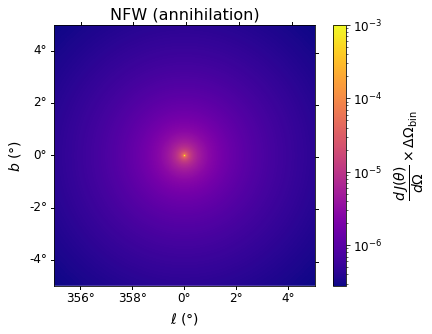

In [27]:
profile_plot(nfw_annih, l1, b1, wcs1, cmap=plt.cm.plasma, norm=colors.LogNorm(vmin=nfw_annih.min(), vmax=nfw_annih.max()))
plt.title("NFW (annihilation)")
plt.show()

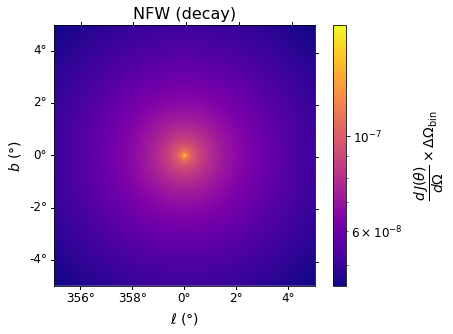

In [28]:
profile_plot(nfw_decay, l1, b1, wcs1, cmap=plt.cm.plasma, norm=colors.LogNorm(vmin=nfw_decay.min(), vmax=nfw_decay.max()))
plt.title("NFW (decay)")
plt.show()

In [29]:
generate_fits(nfw_annih, wcs1, 'maps/nfw_annih10deg.fits')

In [ ]:
generate_fits(nfw_decay, wcs1, 'maps/nfw_decay10deg.fits', factor_type='decay')

# Consistency check

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

## Utils

In [3]:
def get_fits_data(filename):
    with fits.open(filename) as hdul:
        data = hdul[0].data
    return data

In [4]:
def j_bar(data, apertures, mask):
    return data[mask].sum()/apertures[mask].sum()

## Loading Maps

* Aperture Map 

In [8]:
apertures = get_fits_data('maps/apertures-10deg.fits')

* $\theta$ Map

In [9]:
thetas = get_fits_data('maps/thetas-10deg.fits')

* NFW

In [10]:
nfw_annih = get_fits_data('maps/nfw_annih10deg.fits')
nfw_decay = get_fits_data('maps/nfw_decay10deg.fits')

### Region 5º x 5º

In [11]:
theta2 = 10*np.pi/180.0
mask2 = (thetas <= theta2)

In [12]:
j_bar(nfw_annih, apertures, mask2)

174.0514687438021

In [14]:
j_bar(nfw_decay, apertures, mask2)

11.751718771764832